## Tasks

1. Is the test winning? 
2. Is the test performing similarly for all user segments or are there differences among different segments?
3. If you identified segments that responded differently to the test, can you guess the reason? Would this change your point 1 conclusions?

In [1]:
#!unzip Engagement_Test.zip

In [2]:
!cat test_table.csv | head -3

"user_id","date","browser","test","pages_visited"
600597,2015-08-13,"IE",0,2
4410028,2015-08-26,"Chrome",1,5
cat: stdout: Broken pipe


In [3]:
!cat user_table.csv | head -4

"user_id","signup_date"
34,2015-01-01
59,2015-01-01
178,2015-01-01
cat: stdout: Broken pipe


In [4]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
test_df = pd.read_csv("test_table.csv")
user_df = pd.read_csv("user_table.csv")
print("Test has shape: {}, User has shape: {}".format(test_df.shape, user_df.shape))
df = pd.merge(left = test_df, right = user_df, how='inner')

Test has shape: (100000, 5), User has shape: (100000, 2)


In [6]:
df.head(3)

,user_id,date,browser,test,pages_visited,signup_date
0,600597,2015-08-13,IE,0,2,2015-01-19
1,4410028,2015-08-26,Chrome,1,5,2015-05-11
2,6004777,2015-08-17,Chrome,0,8,2015-06-26


**1. A/B test result**

/Users/parker/anaconda/lib/python3.6/site-packages/pandas/plotting/_core.py:2396: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  yrot=yrot, **kwds)


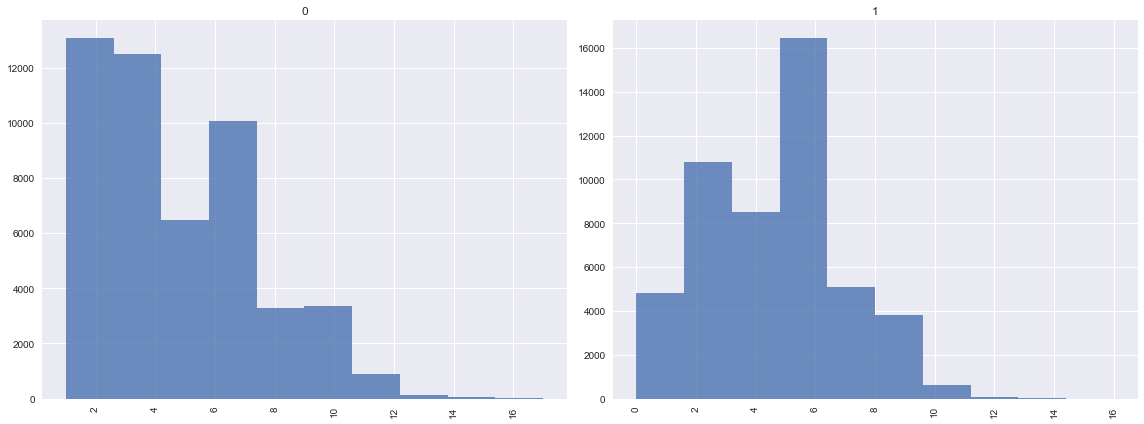

In [7]:
#first visualize, we see that the distribution is quite different for two groups
fig, ax = plt.subplots(ncols = 2,nrows=1, figsize=(16,6))
df.hist(column = 'pages_visited', by = 'test', ax = ax[0], alpha = 0.8)
plt.tight_layout()

Based on below result, we see that p-value is much bigger than 0.05 significance level, meaning that there is no statistically significant difference for 2 groups.

So the test did not win, and should not expand to all users

In [8]:
#perform the test
from scipy.stats import ttest_ind
control_page_visits = df.loc[df['test'] == 0, 'pages_visited']
test_page_visits = df.loc[df['test'] == 1, 'pages_visited']
t_stat, p_val = ttest_ind(a = control_page_visits, b = test_page_visits)
print("P-value is: {:.3f}".format(p_val))
if p_val > 0.05:
    print("P-value does not show statistical significance")
else:
    print("P-value shows statistical significance")

P-value is: 0.577
P-value does not show statistical significance


**2&3. compare test for different segments**

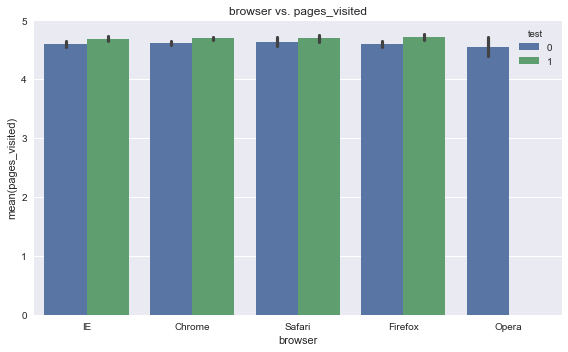

In [9]:
#first compare by browser
fig, ax = plt.subplots(nrows = 1, ncols = 1,figsize= (8,5))
sns.barplot(x = 'browser', y ='pages_visited', data = df, hue='test', ax = ax)
ax.set_title("browser vs. pages_visited")
plt.tight_layout()

Based on above plot, we observe an abnormal value for **Opera**: its test group people all have **0** pages visited. This might be a data logging error, so let's remove Opera from original dataset and do the t-test again

In [10]:
no_opera_df = df[df['browser'] != 'Opera']
print(df.shape, '  ', no_opera_df.shape)
no_opera_control = no_opera_df.loc[no_opera_df['test'] == 0, 'pages_visited']
no_opera_test = no_opera_df.loc[no_opera_df['test'] == 1, 'pages_visited']
t, p = ttest_ind(a = no_opera_control, b = no_opera_test)
print("After removing Opera, p-value is now: {}".format(p))

(100000, 6)    (97873, 6)
After removing Opera, p-value is now: 4.273456891094664e-08


Now after removing **Opera** data, we find p-value to be 4.27e-08, which is much lower than 0.05 significance level. And now we can conclude that test wins

In [11]:
#compare by day of week, and interval to check novelty effect
df['date'] = pd.to_datetime(df['date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['dayofweek'] = df['date'].apply(lambda x:x.dayofweek)
df['interval'] = (df['date'] - df['signup_date']).apply(lambda x: x.days)
df['new_user'] = (df['interval'] < 10).astype('int')
df.head(5)

,user_id,date,browser,test,pages_visited,signup_date,dayofweek,interval,new_user
0,600597,2015-08-13,IE,0,2,2015-01-19,3,206,0
1,4410028,2015-08-26,Chrome,1,5,2015-05-11,2,107,0
2,6004777,2015-08-17,Chrome,0,8,2015-06-26,0,52,0
3,5990330,2015-08-27,Safari,0,8,2015-06-25,3,63,0
4,3622310,2015-08-07,Firefox,0,1,2015-04-17,4,112,0


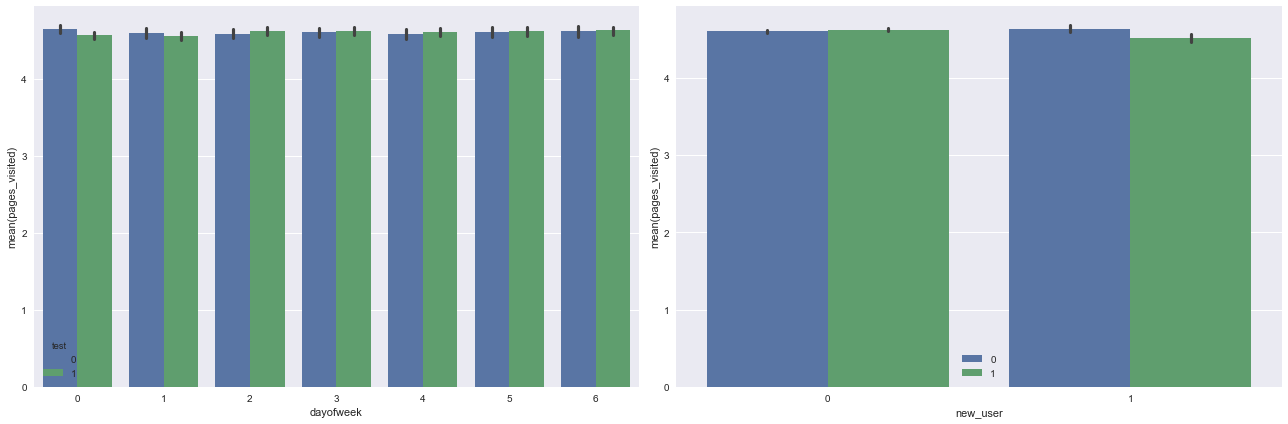

In [17]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(18,6))
sns.barplot(x = 'dayofweek', y = 'pages_visited', hue='test', data = df, ax = ax[0])
sns.barplot(x = 'new_user', y ='pages_visited', hue = 'test', data = df, ax=ax[1])
plt.legend()
plt.tight_layout()

In [24]:
#compare new user 
new_df = df.copy()
new_df = new_df[new_df['browser'] != 'Opera']
new_user_control = new_df.loc[(new_df['new_user'] == 1) & (new_df['test'] == 0), 'pages_visited']
new_user_test = new_df.loc[(new_df['new_user'] == 1) & (new_df['test'] == 1), 'pages_visited']
t, p = ttest_ind(a = new_user_control, b = new_user_test)
print("For new users, p-value is : {}".format(p))

For new users, p-value is : 0.19139214817570446


In [26]:
#compare old user
old_user_control = new_df.loc[(new_df['new_user'] == 0) & (new_df['test'] == 0), 'pages_visited']
old_user_test = new_df.loc[(new_df['new_user'] == 0) & (new_df['test'] == 1), 'pages_visited']
t, p = ttest_ind(a = old_user_control, b = old_user_test)
print("For old users, p-value is : {}".format(p))

For old users, p-value is : 1.4975217073177642e-12


Based on above analysis, we did not find a statistically significant result for new users, but there is a statistically significant result for old users, meaning that there is a novelty effect, and therefore, the statistically significant result cannot be fully trusted, and I would suggest **not expanding** this feature to all user groups